# First very rough try at Gaussian process through Earth-Moon data

by *Niels J. de Winter* **n.j.de.winter@vu.nl**

### Inspiration by the following references:
* https://hendersontrent.github.io/posts/2024/05/gaussian-process-time-series/
* https://distill.pub/2019/visual-exploration-gaussian-processes/
* https://www.cs.toronto.edu/~duvenaud/cookbook/

In [34]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import cholesky, cho_solve, solve_triangular
from numpy.linalg import inv, solve
# from scipy.linalg import cho_solve
from scipy.optimize import minimize, LinearConstraint
from scipy.interpolate import interp1d

## Input manually estimated data based on Williams et al. (2000)

In [35]:
# Manually estimated data with rough error bars from the Figure 2 in Williams et al. (2000)
data = [
    {"Age (Ma)": 620, "Age error": 30, "Days/year": 400, "Days/year error": 10, "Hours/day": 22.0, "Hours/day error": 0.4, "Data type": "Elatina–Reynella"},
    {"Age (Ma)": 600, "Age error": 25, "Days/year": 410, "Days/year error": 10, "Hours/day": 21.4, "Hours/day error": 0.3, "Data type": "Stromatolites, max"},
    {"Age (Ma)": 550, "Age error": 20, "Days/year": 417, "Days/year error": 5, "Hours/day": 21.0, "Hours/day error": 0.2, "Data type": "Stromatolites, mean"},
    {"Age (Ma)": 500, "Age error": 15, "Days/year": 415, "Days/year error": 5, "Hours/day": 21.1, "Hours/day error": 0.2, "Data type": "Brachiopods, max"},
    {"Age (Ma)": 450, "Age error": 10, "Days/year": 410, "Days/year error": 5, "Hours/day": 21.3, "Hours/day error": 0.2, "Data type": "Bivalves, mean"},
    {"Age (Ma)": 400, "Age error": 5, "Days/year": 400, "Days/year error": 5, "Hours/day": 22.0, "Hours/day error": 0.2, "Data type": "Corals, max"},
    {"Age (Ma)": 380, "Age error": 3, "Days/year": 395, "Days/year error": 10, "Hours/day": 22.2, "Hours/day error": 0.3, "Data type": "Corals, mean"},
    {"Age (Ma)": 300, "Age error": 2, "Days/year": 385, "Days/year error": 10, "Hours/day": 22.6, "Hours/day error": 0.3, "Data type": "Corals, mean"},
    {"Age (Ma)": 250, "Age error": 1, "Days/year": 375, "Days/year error": 10, "Hours/day": 23.3, "Hours/day error": 0.3, "Data type": "Brachiopods, max"},
    {"Age (Ma)": 150, "Age error": 1, "Days/year": 370, "Days/year error": 10, "Hours/day": 23.5, "Hours/day error": 0.3, "Data type": "Brachiopods, max"},
    {"Age (Ma)": 0, "Age error": 0, "Days/year": 365.25, "Days/year error": 0, "Hours/day": 24.0, "Hours/day error": 0, "Data type": "Modern value"},
]

df = pd.DataFrame(data)
df.head()

,Age (Ma),Age error,Days/year,Days/year error,Hours/day,Hours/day error,Data type
0,620,30,400.0,10,22.0,0.4,Elatina–Reynella
1,600,25,410.0,10,21.4,0.3,"Stromatolites, max"
2,550,20,417.0,5,21.0,0.2,"Stromatolites, mean"
3,500,15,415.0,5,21.1,0.2,"Brachiopods, max"
4,450,10,410.0,5,21.3,0.2,"Bivalves, mean"


## Plot dummy data

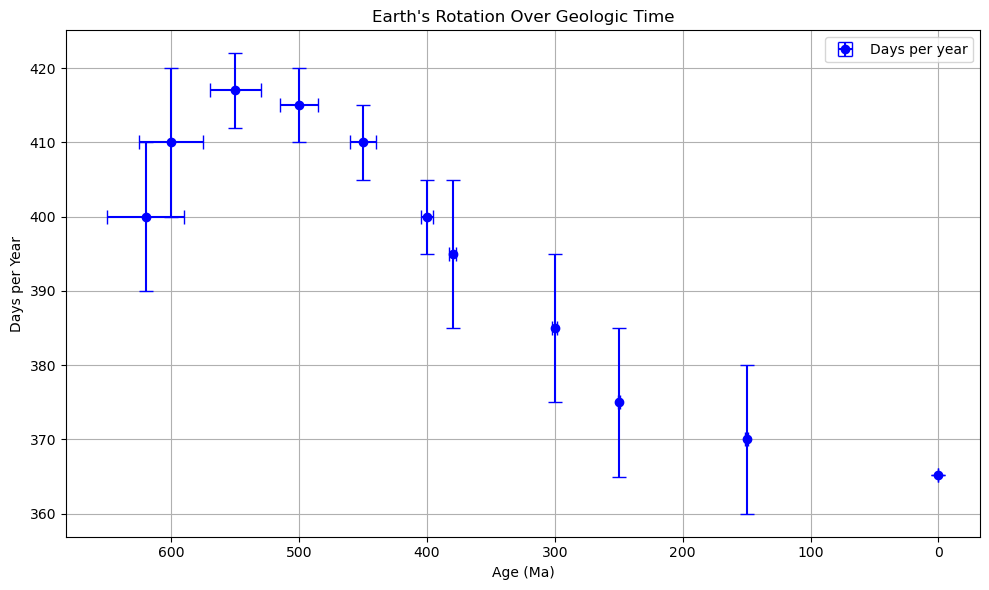

In [36]:
# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(df["Age (Ma)"], df["Days/year"], yerr=df["Days/year error"], xerr=df["Age error"],
             fmt='o', color='blue', capsize=5, label="Days per year")

# Invert x-axis (oldest on left)
plt.gca().invert_xaxis()

# Labels and title
plt.xlabel("Age (Ma)")
plt.ylabel("Days per Year")
plt.title("Earth's Rotation Over Geologic Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Build up Gaussian Progress by experimenting with different kernels

### Define function to sample from kernel

In [37]:
# Define function to sample from kernel
def sample_from_kernel(n, X, Sigma, k = 5, mu = 0):
    """
    Sample from a Gaussian process defined by a kernel.
    
    Parameters:
    n (int): Number of samples to draw.
    k (int): Number of realizations to draw.
    mu (float): Mean of the Gaussian process.
    X (array-like): Input data points.
    Sigma (array-like): Covariance matrix.
    
    Returns:
    array: Sampled points from the Gaussian process.
    """
    # Prepare mean vector if mu = 0
    if mu == 0:
        mu = np.zeros(n)
    
    # Produce dynamic column names, draw from multivariate normal distribution, and convert to DataFrame
    thenames = [f"Sample {i+1}" for i in range(k)]

    samples = np.random.multivariate_normal(mu, Sigma, size=k).transpose()
   
    df_samples = pd.DataFrame(samples, columns=thenames)
 
    # Add the input data points as a new column
    df_samples['Age (Ma)'] = X.flatten()
    # return(df_samples)

    # Plot the sampled points
    plt.figure(figsize=(10, 6))
    for i in range(k):
        plt.plot(df_samples['Age (Ma)'], df_samples[thenames[i]], label=f'Sample {i+1}')
    plt.xlabel('Age (Ma)')
    plt.ylabel('Sampled Values')
    plt.title('Samples from Gaussian Process')
    plt.legend()

## Start with Exponentiated Quadratic Kernel (= Radial Basis Function)

### Define Exponentiated quadratic kernel (Radial Basis Function)

In [38]:
# Define Radial Basis Function kernel function
def rbf_kernel(X1, X2, lengthscale=1.0, variance=1.0):
    """Radial Basis Function (RBF) kernel"""
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + \
             np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return variance * np.exp(-0.5 / lengthscale**2 * sqdist)

### Create simple RBF matrix as example

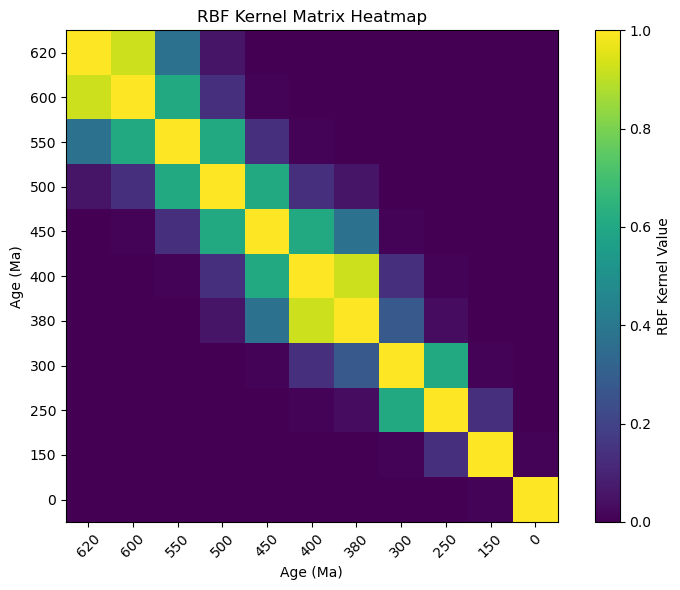

In [39]:
mat_rbf = rbf_kernel(df["Age (Ma)"].values.reshape(-1, 1), df["Age (Ma)"].values.reshape(-1, 1), lengthscale=50, variance=1.0) # RBF kernel matrix
# Plot the RBF matrix as heatmap
plt.figure(figsize=(8, 6))
plt.imshow(mat_rbf, cmap='viridis', interpolation='nearest')
plt.colorbar(label='RBF Kernel Value')
plt.title('RBF Kernel Matrix Heatmap')
plt.xlabel('Age (Ma)')
plt.ylabel('Age (Ma)')
plt.xticks(ticks=np.arange(len(df["Age (Ma)"])), labels=df["Age (Ma)"], rotation=45)
plt.yticks(ticks=np.arange(len(df["Age (Ma)"])), labels=df["Age (Ma)"])
plt.tight_layout()

### Example: Draw samples from kernel and plot

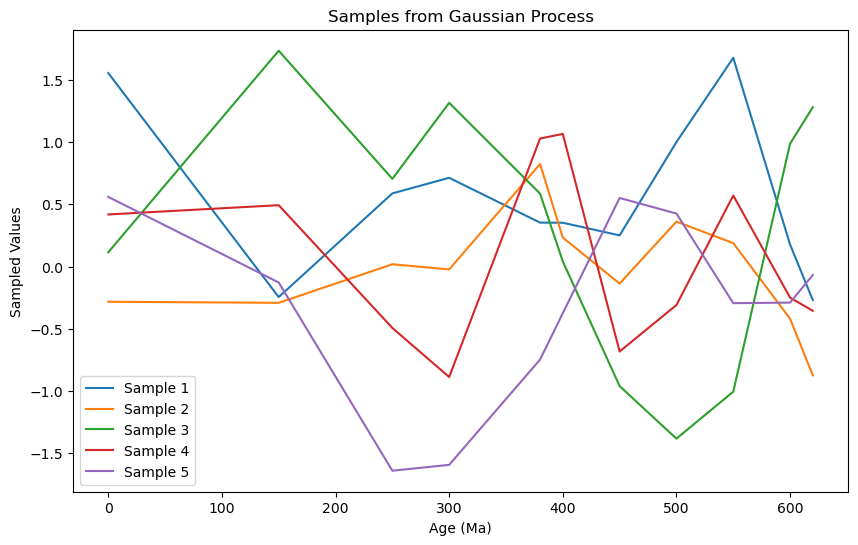

In [40]:
sample_from_kernel(n = mat_rbf.shape[0], X = df["Age (Ma)"].values.reshape(-1, 1), Sigma = mat_rbf, k = 5, mu = 0)
plt.show()
# print(samples)

### Example 2: Draw higher resolution samples from kernel and plot

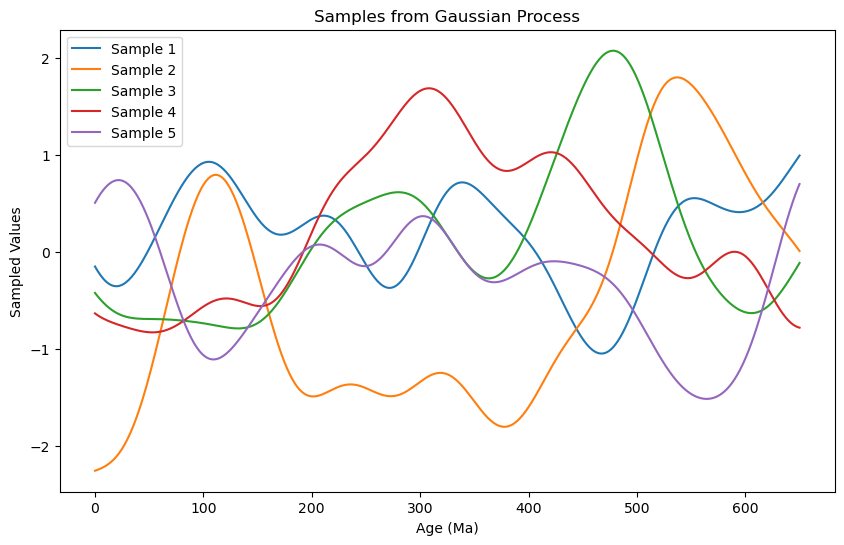

In [41]:
# Gerenate higher resolution RBF kernel matrix
mat_rbf = rbf_kernel(np.linspace(0, 650, 500).reshape(-1, 1), np.linspace(0, 650, 500).reshape(-1, 1), lengthscale=50, variance=1.0)

sample_from_kernel(n = mat_rbf.shape[0], X = np.linspace(0, 650, 500).reshape(-1, 1), Sigma = mat_rbf, k = 5, mu = 0)
plt.show()
# print(samples)

### Example 3: Draw higher resolution samples from kernel with smaller length scale and plot

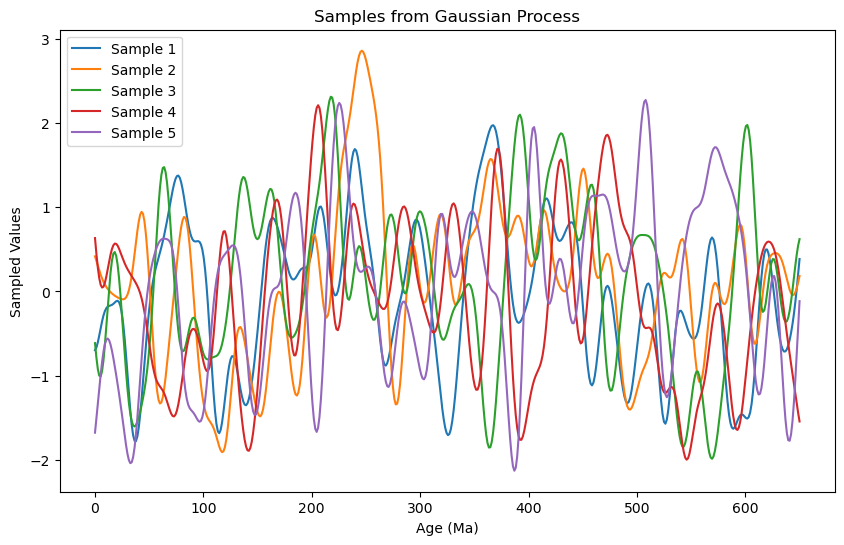

In [42]:
# Gerenate higher resolution RBF kernel matrix
mat_rbf = rbf_kernel(np.linspace(0, 650, 500).reshape(-1, 1), np.linspace(0, 650, 500).reshape(-1, 1), lengthscale=10, variance=1.0)

sample_from_kernel(n = mat_rbf.shape[0], X = np.linspace(0, 650, 500).reshape(-1, 1), Sigma = mat_rbf, k = 5, mu = 0)
plt.show()
# print(samples)

### Heatmap of regular RBF kernel using higher resolution matrix

In [43]:
len(np.linspace(0, 650, 50))

50

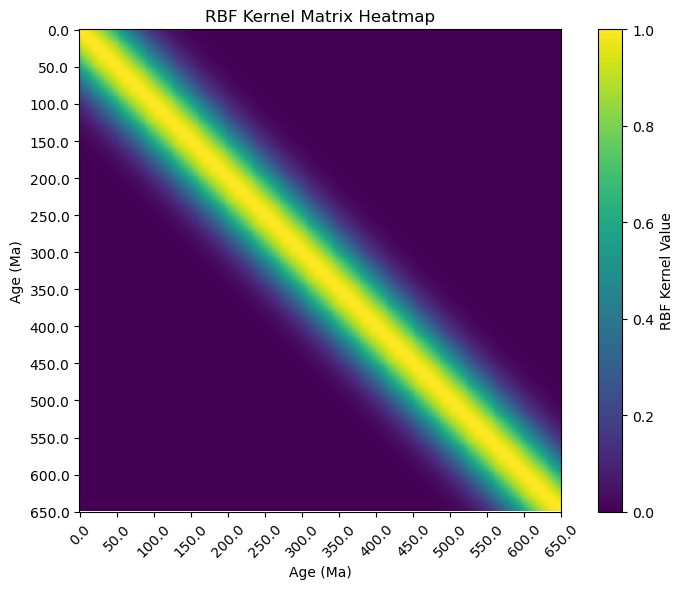

In [44]:
mat_rbf = rbf_kernel(np.linspace(0, 650, 500).reshape(-1, 1), np.linspace(0, 650, 500).reshape(-1, 1), lengthscale=50, variance=1.0)
# Plot the RBF matrix as heatmap
plt.figure(figsize=(8, 6))
plt.imshow(mat_rbf, cmap='viridis', interpolation='nearest')
plt.colorbar(label='RBF Kernel Value')
plt.title('RBF Kernel Matrix Heatmap')
plt.xlabel('Age (Ma)')
plt.ylabel('Age (Ma)')
plt.xticks(ticks=np.linspace(0, 500, 14), labels=np.linspace(0, 650, 14), rotation=45)
plt.yticks(ticks=np.linspace(0, 500, 14), labels=np.linspace(0, 650, 14))
plt.tight_layout()

### Heatmap of more wiggly (shorter length scale) RBF kernel

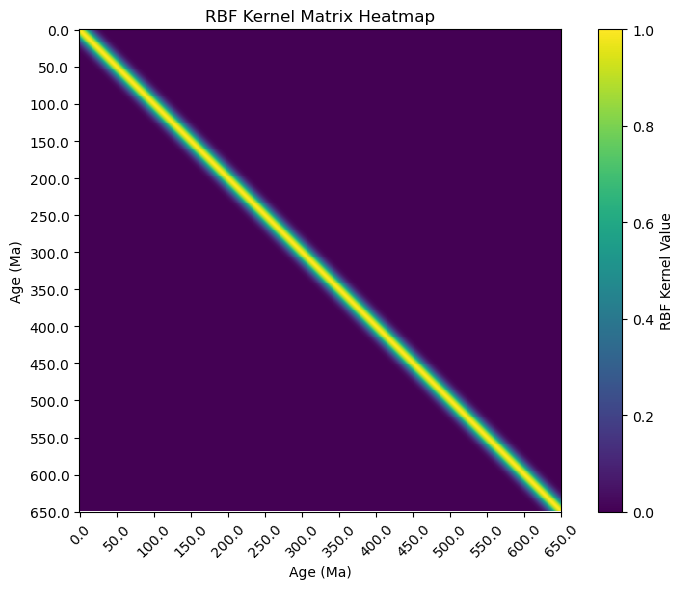

In [45]:
mat_rbf = rbf_kernel(np.linspace(0, 650, 500).reshape(-1, 1), np.linspace(0, 650, 500).reshape(-1, 1), lengthscale=10, variance=1.0)
# Plot the RBF matrix as heatmap
plt.figure(figsize=(8, 6))
plt.imshow(mat_rbf, cmap='viridis', interpolation='nearest')
plt.colorbar(label='RBF Kernel Value')
plt.title('RBF Kernel Matrix Heatmap')
plt.xlabel('Age (Ma)')
plt.ylabel('Age (Ma)')
plt.xticks(ticks=np.linspace(0, 500, 14), labels=np.linspace(0, 650, 14), rotation=45)
plt.yticks(ticks=np.linspace(0, 500, 14), labels=np.linspace(0, 650, 14))
plt.tight_layout()

## Now try the Rational Quadratic Kernel 

### Create function for RQK

In [46]:
# Define Rational Quadratic Kernel function
def rq_kernel(X1, X2, lengthscale=1.0, variance=1.0, alpha=1.0):
    """Rational Quadratic (RQ) kernel"""
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + \
             np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return variance * (1 + sqdist / (2 * alpha * lengthscale**2))**(-alpha)

### Example 4: Sample from Rational Quadratic Kernel

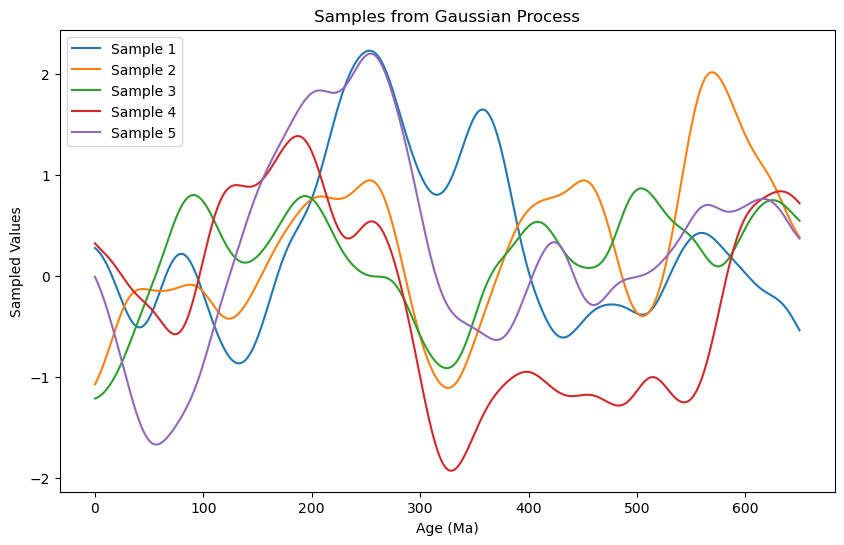

In [47]:
# Gerenate higher resolution RQK kernel matrix
mat_rq = rq_kernel(np.linspace(0, 650, 500).reshape(-1, 1), np.linspace(0, 650, 500).reshape(-1, 1), lengthscale = 50, variance = 1.0, alpha = 1.0)

sample_from_kernel(n = mat_rq.shape[0], X = np.linspace(0, 650, 500).reshape(-1, 1), Sigma = mat_rq, k = 5, mu = 0)
plt.show()
# print(samples)

### Example 5: Sample from Rational Quadratic Kernel with smaller length scale

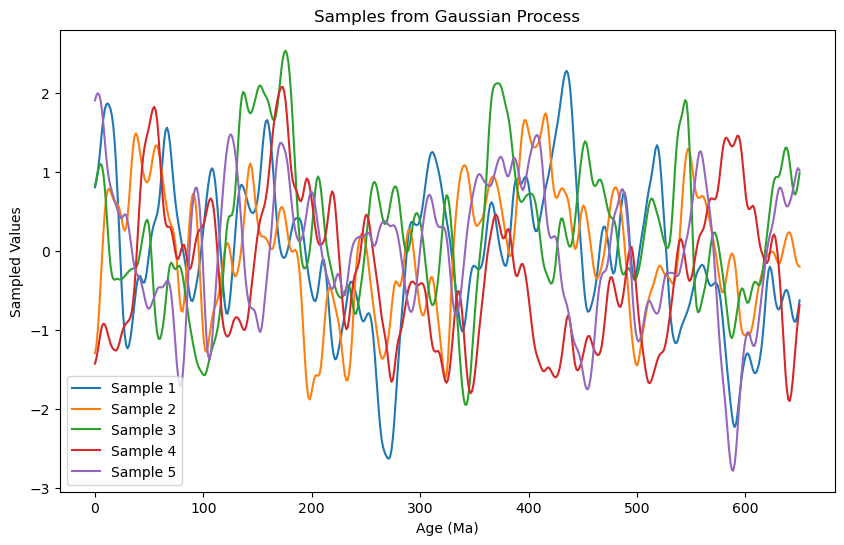

In [48]:
# Gerenate higher resolution RQK kernel matrix
mat_rq = rq_kernel(np.linspace(0, 650, 500).reshape(-1, 1), np.linspace(0, 650, 500).reshape(-1, 1), lengthscale=10, variance=1.0, alpha = 1.0)

sample_from_kernel(n = mat_rq.shape[0], X = np.linspace(0, 650, 500).reshape(-1, 1), Sigma = mat_rq, k = 5, mu = 0)
plt.show()
# print(samples)

### Example 6: Sample from Rational Quadratic Kernel with smaller alpha

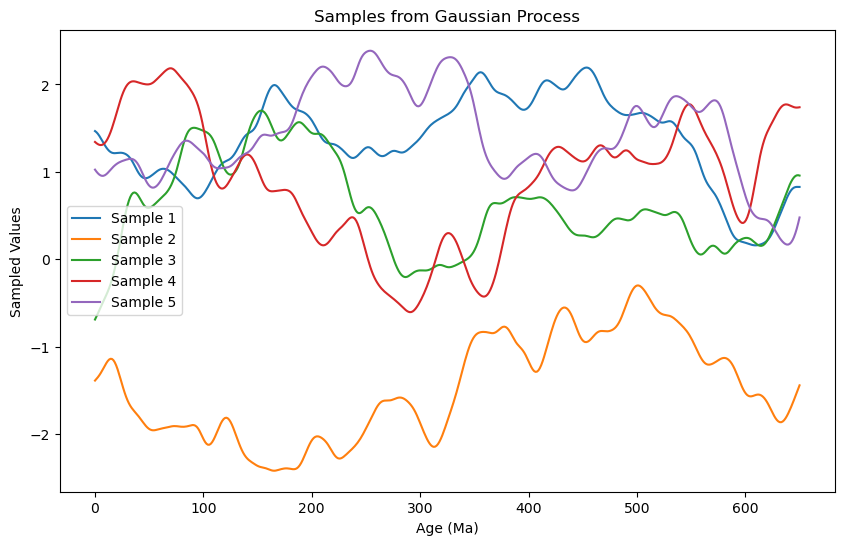

In [49]:
# Gerenate higher resolution RQK kernel matrix
mat_rq = rq_kernel(np.linspace(0, 650, 500).reshape(-1, 1), np.linspace(0, 650, 500).reshape(-1, 1), lengthscale=50, variance=1.0, alpha = 0.1)

sample_from_kernel(n = mat_rq.shape[0], X = np.linspace(0, 650, 500).reshape(-1, 1), Sigma = mat_rq, k = 5, mu = 0)
plt.show()
# print(samples)

### Heatmap of regular RQ kernel

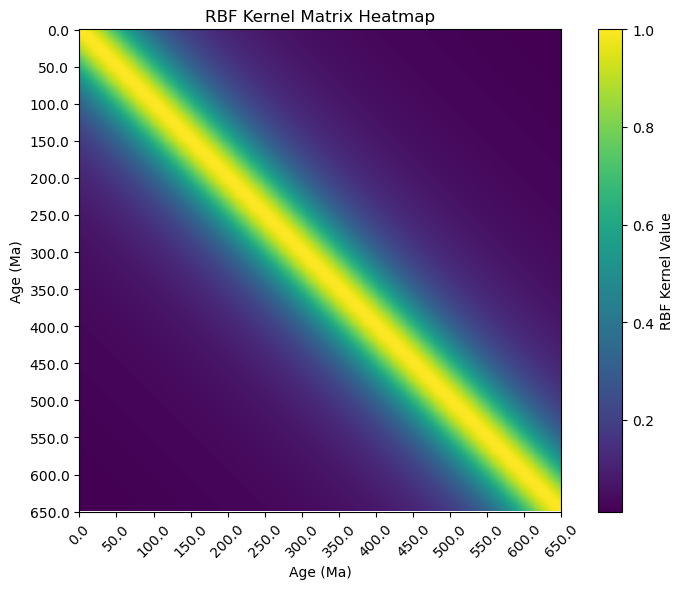

In [50]:
mat_rq = rq_kernel(np.linspace(0, 650, 1000).reshape(-1, 1), np.linspace(0, 650, 1000).reshape(-1, 1), lengthscale=50, variance=1.0, alpha = 1.0)
# Plot the RBF matrix as heatmap
plt.figure(figsize=(8, 6))
plt.imshow(mat_rq, cmap='viridis', interpolation='nearest')
plt.colorbar(label='RBF Kernel Value')
plt.title('RBF Kernel Matrix Heatmap')
plt.xlabel('Age (Ma)')
plt.ylabel('Age (Ma)')
plt.xticks(ticks=np.linspace(0, 1000, 14), labels=np.linspace(0, 650, 14), rotation=45)
plt.yticks(ticks=np.linspace(0, 1000, 14), labels=np.linspace(0, 650, 14))
plt.tight_layout()

### Heatmap of RQ kernel with lower alpha

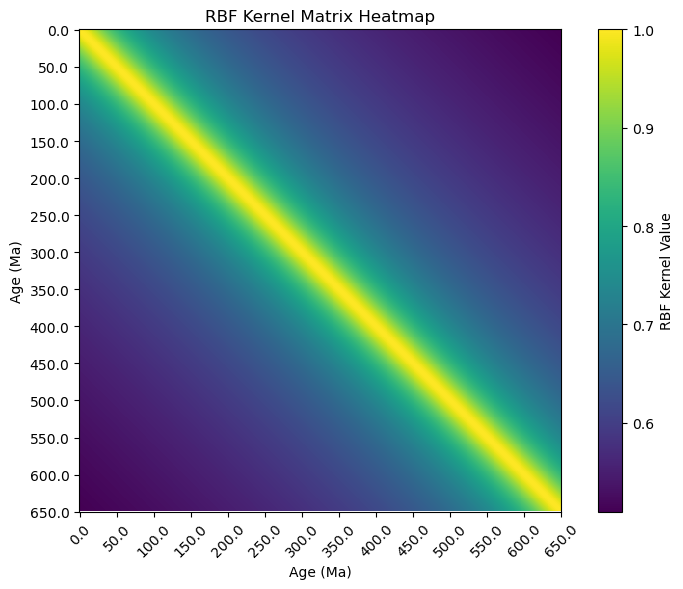

In [51]:
mat_rq = rq_kernel(np.linspace(0, 650, 500).reshape(-1, 1), np.linspace(0, 650, 500).reshape(-1, 1), lengthscale=50, variance=1.0, alpha = 0.1)
# Plot the RBF matrix as heatmap
plt.figure(figsize=(8, 6))
plt.imshow(mat_rq, cmap='viridis', interpolation='nearest')
plt.colorbar(label='RBF Kernel Value')
plt.title('RBF Kernel Matrix Heatmap')
plt.xlabel('Age (Ma)')
plt.ylabel('Age (Ma)')
plt.xticks(ticks=np.linspace(0, 500, 14), labels=np.linspace(0, 650, 14), rotation=45)
plt.yticks(ticks=np.linspace(0, 500, 14), labels=np.linspace(0, 650, 14))
plt.tight_layout()

## Now define and try white noise kernel

### Define covariance matrix of white noise kernel

In [52]:
# Define White Noise Kernel function
def white_noise_kernel(X1, X2, variance=1.0):
    """White Noise kernel"""
    if X1.shape[0] != X2.shape[0]:
        raise ValueError("Input arrays must have the same number of points.")
    return variance * np.eye(X1.shape[0]) # Multiply variance by identity matrix

### Example 7: Sample from white noise kernel

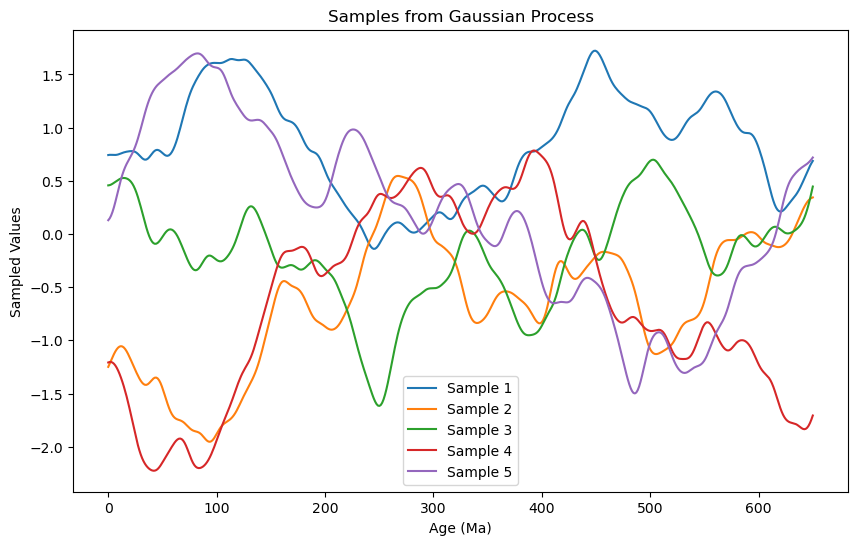

In [53]:
# Gerenate higher resolution RQK kernel matrix
mat_wn = rq_kernel(np.linspace(0, 650, 500).reshape(-1, 1), np.linspace(0, 650, 500).reshape(-1, 1), variance=1.0)

sample_from_kernel(n = mat_wn.shape[0], X = np.linspace(0, 650, 500).reshape(-1, 1), Sigma = mat_rq, k = 5, mu = 0)
plt.show()
# print(samples)

### Heatmap of White Noise kernel

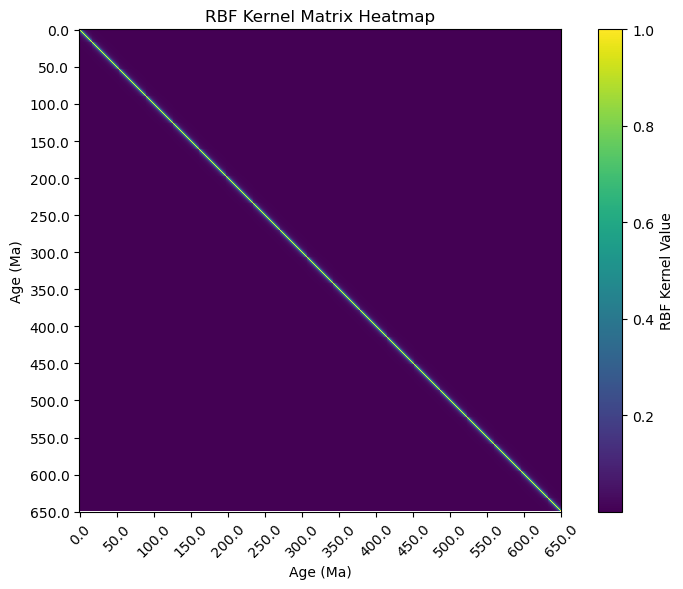

In [54]:
# Plot the RBF matrix as heatmap
plt.figure(figsize=(8, 6))
plt.imshow(mat_wn, cmap='viridis', interpolation='nearest')
plt.colorbar(label='RBF Kernel Value')
plt.title('RBF Kernel Matrix Heatmap')
plt.xlabel('Age (Ma)')
plt.ylabel('Age (Ma)')
plt.xticks(ticks=np.linspace(0, 500, 14), labels=np.linspace(0, 650, 14), rotation=45)
plt.yticks(ticks=np.linspace(0, 500, 14), labels=np.linspace(0, 650, 14))
plt.tight_layout()

## Define linear kernel

In [55]:
# Define linear Kernel function
def linear_kernel(X1, X2, variance=1.0, variance_b=1.0, c=0.0):
    """Linear kernel: k(x, x') = variance * (x-c)(x'-c) + variance_b"""
    return variance * (X1 - c) @ (X2 - c).T + variance_b

### Heatmap of linear kernel

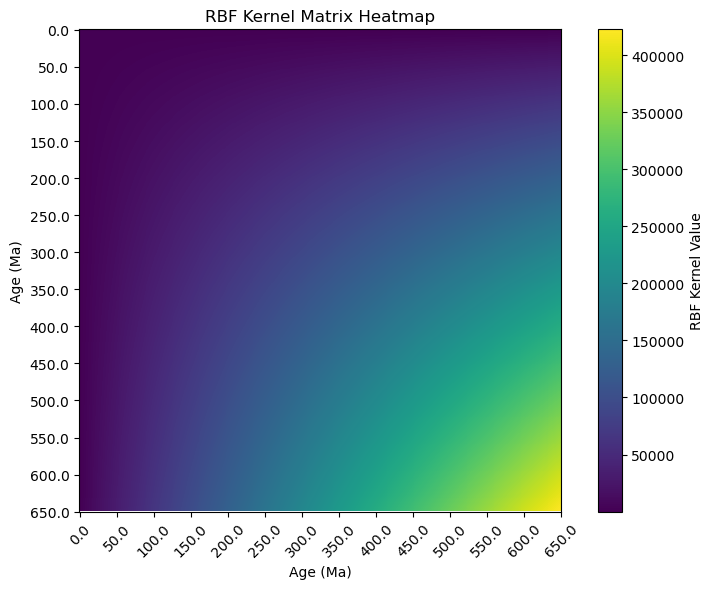

In [56]:
mat_lin = linear_kernel(np.linspace(0, 650, 500).reshape(-1, 1), np.linspace(0, 650, 500).reshape(-1, 1), variance = 1.0, variance_b = 1.0, c = 0.0)
# Plot the RBF matrix as heatmap
plt.figure(figsize=(8, 6))
plt.imshow(mat_lin, cmap='viridis', interpolation='nearest')
plt.colorbar(label='RBF Kernel Value')
plt.title('RBF Kernel Matrix Heatmap')
plt.xlabel('Age (Ma)')
plt.ylabel('Age (Ma)')
plt.xticks(ticks=np.linspace(0, 500, 14), labels=np.linspace(0, 650, 14), rotation=45)
plt.yticks(ticks=np.linspace(0, 500, 14), labels=np.linspace(0, 650, 14))
plt.tight_layout()

### Heatmap of linear kernel with offset

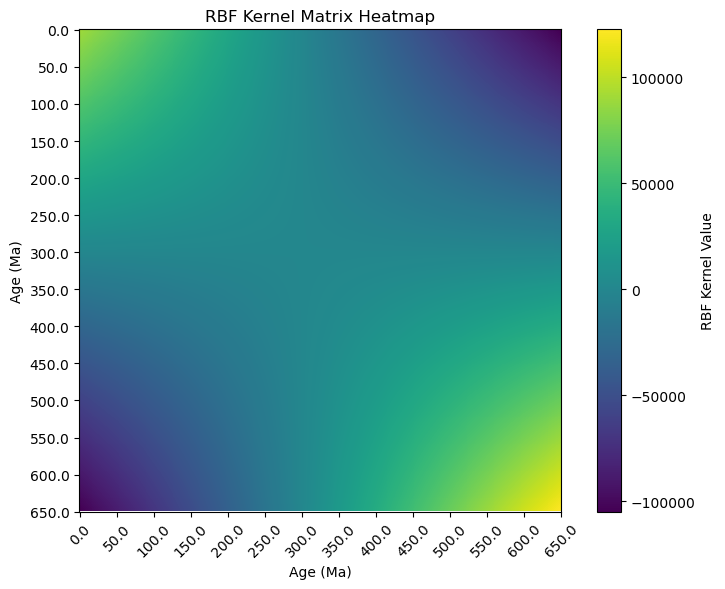

In [57]:
mat_lin = linear_kernel(np.linspace(0, 650, 500).reshape(-1, 1), np.linspace(0, 650, 500).reshape(-1, 1), variance = 1.0, variance_b = 1.0, c = 300)
# Plot the RBF matrix as heatmap
plt.figure(figsize=(8, 6))
plt.imshow(mat_lin, cmap='viridis', interpolation='nearest')
plt.colorbar(label='RBF Kernel Value')
plt.title('RBF Kernel Matrix Heatmap')
plt.xlabel('Age (Ma)')
plt.ylabel('Age (Ma)')
plt.xticks(ticks=np.linspace(0, 500, 14), labels=np.linspace(0, 650, 14), rotation=45)
plt.yticks(ticks=np.linspace(0, 500, 14), labels=np.linspace(0, 650, 14))
plt.tight_layout()

## Now create a composite kernel for the Earth-Moon data

In [58]:
# Start by defining different kernels:
cov_rbf = rbf_kernel(np.linspace(0, 650, 500).reshape(-1, 1), np.linspace(0, 650, 500).reshape(-1, 1), lengthscale=50, variance=50) # Exponentiated Quadratic Kernel (= Radial Basis Function)
cov_lin = linear_kernel(np.linspace(0, 650, 500).reshape(-1, 1), np.linspace(0, 650, 500).reshape(-1, 1), variance=0.1, variance_b=-0.1, c=200) # Linear kernal
cov_wn = white_noise_kernel(np.linspace(0, 650, 500).reshape(-1, 1), np.linspace(0, 650, 500).reshape(-1, 1), variance=20) # White noise kernel

# Add up kernels
cov_combined = cov_rbf + cov_lin + cov_wn

### Heatmap of combined kernel

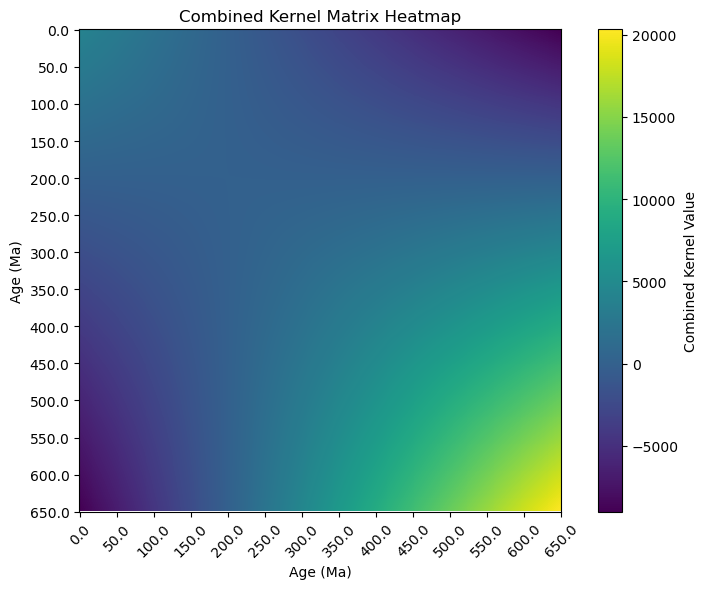

In [59]:
# Plot the combined matrix as heatmap
plt.figure(figsize=(8, 6))
plt.imshow(cov_combined, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Combined Kernel Value')
plt.title('Combined Kernel Matrix Heatmap')
plt.xlabel('Age (Ma)')
plt.ylabel('Age (Ma)')
plt.xticks(ticks=np.linspace(0, 500, 14), labels=np.linspace(0, 650, 14), rotation=45)
plt.yticks(ticks=np.linspace(0, 500, 14), labels=np.linspace(0, 650, 14))
plt.tight_layout()

### Sample from combined kernel

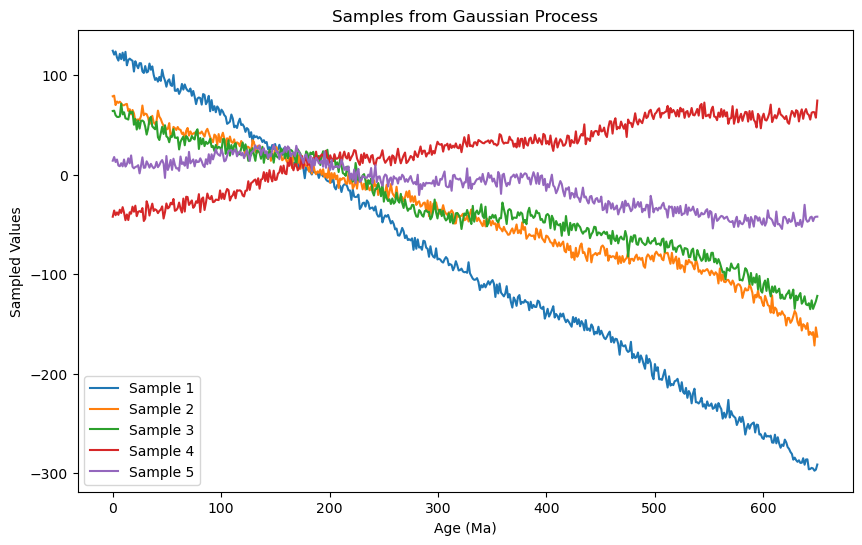

In [60]:
# Sample from combined kernel
sample_from_kernel(n = cov_combined.shape[0], X = np.linspace(0, 650, 500).reshape(-1, 1), Sigma = cov_combined, k = 5, mu = 0)
plt.show()
# print(samples)

In [61]:
## Define function for composite kernel, combining RBF and Linear kernels
def combined_kernel(X1, X2, sigma1 = 1, sigma2 = 1, sigmab = 1, lengthscale=1.0, c=0.0):
    """ Combined kernel: sum of Radial Basis Function with Linear kernels
        Parameters:
    sigma1 (float): Variance of the RBF kernel.
    sigma2 (float): Variance of the Linear kernel.
    sigmab (float): Bias (slope) variance of the Linear kernel.
    lengthscale (float): Lengthscale of the RBF kernel.
    c (float): Offset for the Linear kernel.
    
    Returns:
    numpy.ndarray: Combined kernel matrix.
    """
    return (rbf_kernel(X1, X2, lengthscale=lengthscale, variance=sigma1) +
            linear_kernel(X1, X2, variance=sigma2, variance_b=sigmab, c=c))

# Put together Gaussian Process

### Define GP function

In [62]:
# Function to calculate posterior mean vector and covariance matrix
def gp_posterior_with_errors(x_train, y_train, y_err, x_test, kernel, noise_variance = 0.05, params = {"sigma1": 1, "sigma2": 1, "sigmab": 1, "lengthscale": 1.0, "c": 0.0}):
    """
    Calculate the posterior mean vector and covariance matrix for Gaussian Process regression.
    
    Parameters:
    x_train (array-like): Training input data points.
    y_train (array-like): Training output data points.
    y_err (array-like): Observation errors for the training output data points.
    x_test (array-like): Test input data points where predictions are to be made.
    kernel (function): Kernel function to compute the covariance matrix.
    noise_variance (float): Variance of the observation noise (sigma of the noise kernel, default = 0.05).
    params (dict): Hyperparameters for the kernel functions.
    
    Returns:
    tuple: Input data, posterior mean vector and covariance matrix for the test points.
    """
    # Compute covariance matrices
    K = kernel(x_train, x_train, **params) + np.diag(y_err**2 + noise_variance) # Prior covariance matrix with noise term
    K_s = kernel(x_train, x_test, **params) # Cross-covariance between training and test points
    K_ss = kernel(x_test, x_test, **params) + 1e-8 * np.eye(len(x_test)) # Prior covariance matrix for test points (add small value for numerical stability)

    # Compute the Cholesky decomposition
    L = cholesky(K, lower=True)

    # Solve for alpha to allow efficient computation of the posterior mean
    alpha = cho_solve((L, True), y_train) # alpha is equal to the training outputs scaled by the inverse of the training covariance

    # Compute the posterior mean
    mu_post = K_s.T @ alpha

    # Compute the posterior covariance
    v = solve_triangular(L, K_s, lower=True) # Solve for v using triangular solve for better numerical stability. v is equal to the covariance between training and test points scaled by the inverse of the training covariance
    cov_post = K_ss - v.T @ v # Posterior covariance is equal to the prior covariance minus the uncertainty reduction

    return mu_post, cov_post

### TEST: Run the Gaussian Process function and plot the resulting posterior means +/- covariance stds without normalization

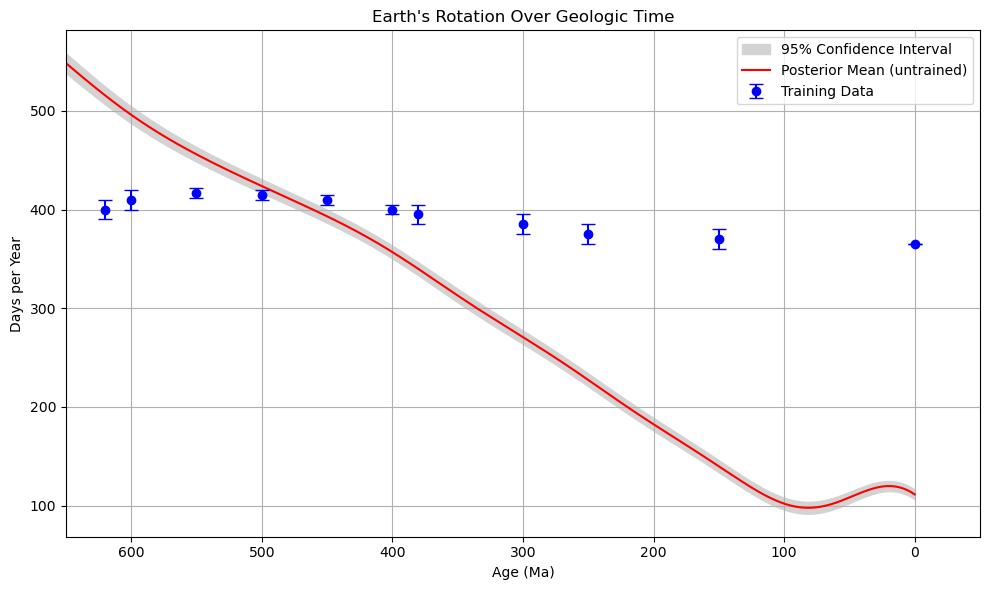

In [63]:
# 1. Prepare data
X_train = df["Age (Ma)"].values.reshape(-1, 1).astype(float)
Y_train = df["Days/year"].values.astype(float)
Y_error = df["Days/year error"].values.astype(float)
X_test = np.linspace(0, 650, 500).reshape(-1, 1)

# # Normalize input
# X_mean = X_train.mean()
# Y_mean = Y_train.mean()
# X_std = X_train.std()
# Y_std = Y_train.std()
# X_train_norm = (X_train - X_mean) / X_std
# X_test_norm = (X_test - X_mean) / X_std
# Y_train_norm = (Y_train - Y_mean) / Y_std

mu_post, cov_post = gp_posterior_with_errors(
    X_train,
    Y_train,
    Y_error,
    X_test,
    combined_kernel,
    noise_variance = 20,
    params = {
        "sigma1": 10,
        "sigma2": 0.1,
        "sigmab": -1,
        "lengthscale": 50,
        "c": 0
    }
)

# # Unnormalize the posterior mean and covariance
# mu_post = mu_post * Y_std + Y_mean
# cov_post = cov_post * (Y_std ** 2)

# Plot mupost with 95% confidence interval
plt.figure(figsize=(10, 6))
plt.fill_between(X_test.flatten(), 
                 mu_post - 1.96 * np.sqrt(np.diag(cov_post)), 
                 mu_post + 1.96 * np.sqrt(np.diag(cov_post)), 
                 color='lightgray', label='95% Confidence Interval')
plt.plot(X_test, mu_post, 'r-', label='Posterior Mean (untrained)')
plt.errorbar(X_train, Y_train, yerr=Y_error, fmt='o', color='blue', capsize=5, label='Training Data')
plt.gca().invert_xaxis()
plt.xlim(650, -50)
plt.xlabel("Age (Ma)")
plt.ylabel("Days per Year")
plt.title("Earth's Rotation Over Geologic Time")
plt.grid(True)
plt.legend()
plt.tight_layout()

### TEST: Run the Gaussian Process function after normalization and plot the resulting posterior means +/- covariance stds

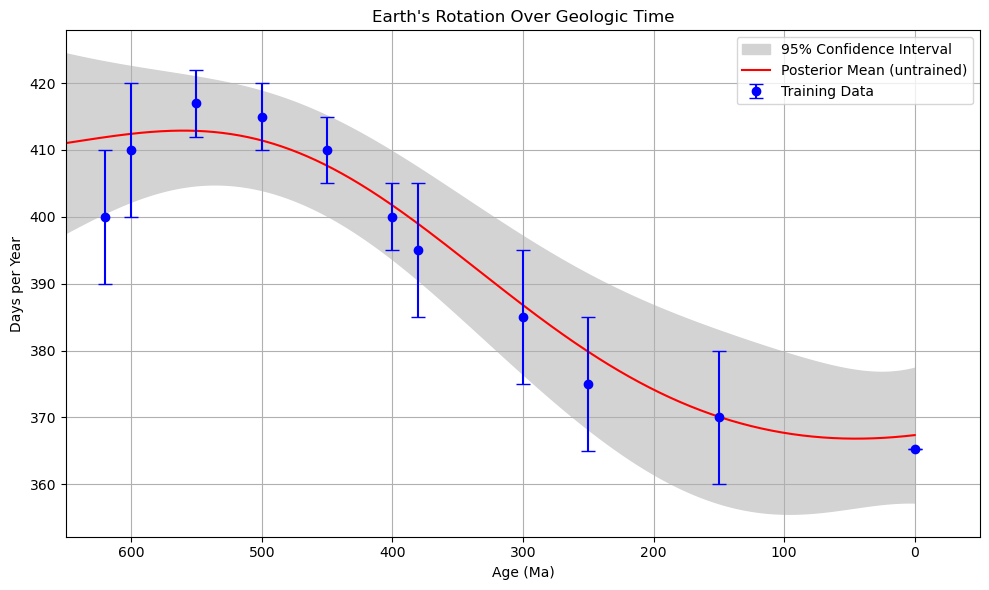

In [64]:
# 1. Prepare data
X_train = df["Age (Ma)"].values.reshape(-1, 1).astype(float)
Y_train = df["Days/year"].values.astype(float)
Y_error = df["Days/year error"].values.astype(float)
X_test = np.linspace(0, 650, 500).reshape(-1, 1) # Test points

# Normalize input
X_mean = X_train.mean()
X_std = X_train.std()
X_train_norm = (X_train - X_mean) / X_std
X_test_norm = (X_test - X_mean) / X_std
Y_mean = Y_train.mean()
Y_std = Y_train.std()
Y_train_norm = (Y_train - Y_mean) / Y_std
Y_error_norm = Y_error / Y_std

# Get posterior mean and covariance
mu_post, cov_post = gp_posterior_with_errors(
    X_train_norm,
    Y_train_norm,
    Y_error_norm,
    X_test_norm,
    combined_kernel,
    noise_variance = 0.1,
    params = {
        "sigma1": 1,
        "sigma2": 0.1,
        "sigmab": -0.3,
        "lengthscale": 1,
        "c": 0
    }
)

# Rescale back to original units
X_train_rescaled, X_test_rescaled = X_train_norm * X_std + X_mean, X_test_norm * X_std + X_mean
Y_train_rescaled, mu_post_rescaled = Y_train_norm * Y_std + Y_mean, mu_post * Y_std + Y_mean
cov_post_rescaled = cov_post * (Y_std ** 2)

# Plot mupost with 95% confidence interval
plt.figure(figsize=(10, 6))
plt.fill_between(X_test_rescaled.flatten(), 
                 mu_post_rescaled - 1.96 * np.sqrt(np.diag(cov_post_rescaled)), 
                 mu_post_rescaled + 1.96 * np.sqrt(np.diag(cov_post_rescaled)), 
                 color='lightgray', label='95% Confidence Interval')
plt.plot(X_test_rescaled, mu_post_rescaled, 'r-', label='Posterior Mean (untrained)')
plt.errorbar(X_train_rescaled, Y_train_rescaled, yerr=Y_error, fmt='o', color='blue', capsize=5, label='Training Data')
plt.gca().invert_xaxis()
plt.xlim(650, -50)
plt.xlabel("Age (Ma)")
plt.ylabel("Days per Year")
plt.title("Earth's Rotation Over Geologic Time")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Optimize hyperparameters of combined kernel using Log-Marginal Likelihood

## Define Negative Log Marginal Likelihood function for combined kernel

In [65]:
def negative_log_marginal_likelihood(params, X_train, Y_train, Y_train_err, kernel):
    # Unpack hyperparameters (enforce positivity with exp for some parameters)
    sigma1 = np.exp(params[0])      # RBF variance
    sigma2 = np.exp(params[1])      # Linear variance
    sigmab = params[2]              # Bias term (can be negative, leave as is)
    lengthscale = np.exp(params[3]) # RBF lengthscale
    c = params[4]                   # Linear offset (can be negative, leave as is)
    noise = np.exp(params[5])       # Noise variance
    
    # Compute prior covariance matrix and add noise based on observation errors
    K = kernel(X_train, X_train, sigma1=sigma1, sigma2=sigma2, sigmab=sigmab,
               lengthscale=lengthscale, c=c)
    K += np.diag(Y_train_err**2 + noise)  # Add observation noise

    # Cholesky decomposition
    try:
        L = cholesky(K, lower=True)
    except np.linalg.LinAlgError:
        return np.inf  # Numerical issue: return large value if K is not positive definite
    
    # Compute log marginal likelihood
    alpha = cho_solve((L, True), Y_train)
    logdet = 2.0 * np.sum(np.log(np.diag(L)))
    mll = -0.5 * Y_train @ alpha - 0.5 * logdet - 0.5 * len(X_train) * np.log(2 * np.pi)
    return -mll  # return negative log marginal likelihood

## Try to find the optimal combination of kernel hyperparameters by minimizing the negative log-marginal likelihood

In [66]:
# 1. Prepare data
X_train = df["Age (Ma)"].values.reshape(-1, 1).astype(float)
Y_train = df["Days/year"].values.astype(float)
Y_error = df["Days/year error"].values.astype(float)
X_test = np.linspace(0, 650, 500).reshape(-1, 1) # Test points

# Normalize input
X_mean = X_train.mean()
X_std = X_train.std()
X_train_norm = (X_train - X_mean) / X_std
X_test_norm = (X_test - X_mean) / X_std
Y_mean = Y_train.mean()
Y_std = Y_train.std()
Y_train_norm = (Y_train - Y_mean) / Y_std
Y_error_norm = Y_error / Y_std

# Initial guess (log space for positivity)
x0 = [np.log(1), np.log(0.1), -0.3, np.log(1), 0, np.log(1e-8)]  # adjust initial values to best guesses

res = minimize(
    negative_log_marginal_likelihood, 
    x0=x0, 
    args=(X_train_norm, Y_train_norm, Y_error_norm, combined_kernel),
    method="L-BFGS-B"
)

print("Optimization success:", res.success)
print("Optimal parameters:", res.x)

print("Optimal sigma1:", np.exp(res.x[0]))
print("Optimal sigma2:", np.exp(res.x[1]))
print("Optimal sigmab:", res.x[2])
print("Optimal normalized lengthscale:", np.exp(res.x[3])) # Rescale back from log
print("Optimal lengthscale:", np.exp(res.x[3]) * X_std + X_mean) # Rescale back from log and into original units
print("Optimal c:", res.x[4])
print("Optimal noise_variance:", np.exp(res.x[5]))

Optimization success: True
Optimal parameters: [ -0.15013815  -2.09750148  -0.44262712   0.20826976   0.43076536
 -18.42068075]
Optimal sigma1: 0.8605890817617237
Optimal sigma2: 0.12276277114721813
Optimal sigmab: -0.4426271151295345
Optimal normalized lengthscale: 1.2315453450883576
Optimal lengthscale: 609.256917684122
Optimal c: 0.4307653628834112
Optimal noise_variance: 9.99999994518868e-09


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


### Run the Gaussian Process function with optimized hyperparameters plot the resulting posterior means +/- covariance stds

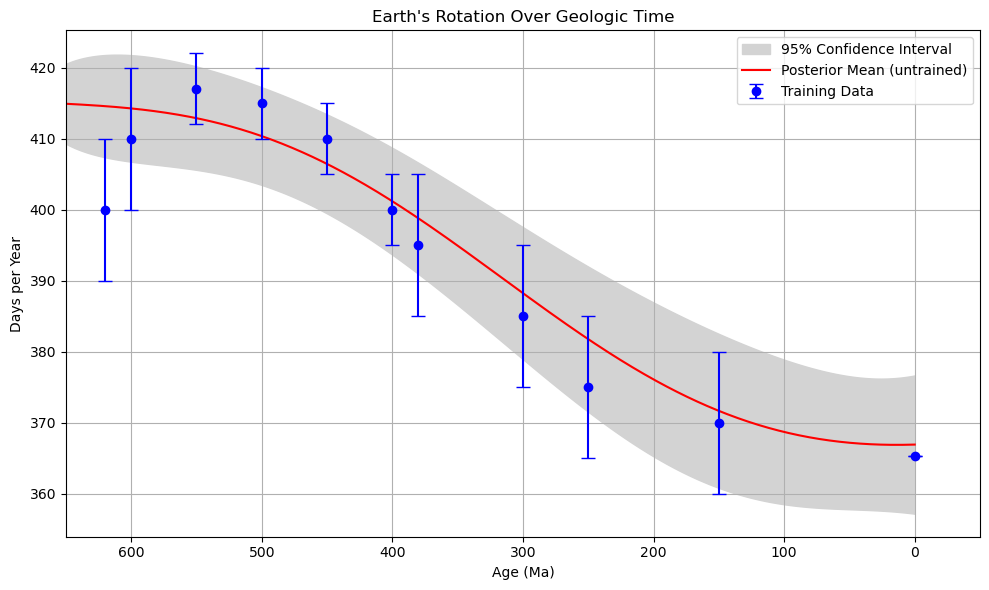

In [67]:
# 1. Prepare data
X_train = df["Age (Ma)"].values.reshape(-1, 1).astype(float)
Y_train = df["Days/year"].values.astype(float)
Y_error = df["Days/year error"].values.astype(float)
X_test = np.linspace(0, 650, 500).reshape(-1, 1) # Test points

# Normalize input
X_mean = X_train.mean()
X_std = X_train.std()
X_train_norm = (X_train - X_mean) / X_std
X_test_norm = (X_test - X_mean) / X_std
Y_mean = Y_train.mean()
Y_std = Y_train.std()
Y_train_norm = (Y_train - Y_mean) / Y_std
Y_error_norm = Y_error / Y_std

# Prepare optimal parameters
opt_params = {
    "sigma1": np.exp(res.x[0]),
    "sigma2": np.exp(res.x[1]),
    "sigmab": res.x[2],
    "lengthscale": np.exp(res.x[3]),
    "c": res.x[4]
}

# Get posterior mean and covariance
mu_post, cov_post = gp_posterior_with_errors(
    X_train_norm,
    Y_train_norm,
    Y_error_norm,
    X_test_norm,
    combined_kernel,
    noise_variance = 0.1,
    params = opt_params
)

# Rescale back to original units
mu_post_rescaled = mu_post * Y_std + Y_mean
cov_post_rescaled = cov_post * (Y_std ** 2)

# Plot mupost with 95% confidence interval
plt.figure(figsize=(10, 6))
plt.fill_between(X_test_rescaled.flatten(), 
                 mu_post_rescaled - 1.96 * np.sqrt(np.diag(cov_post_rescaled)), 
                 mu_post_rescaled + 1.96 * np.sqrt(np.diag(cov_post_rescaled)), 
                 color='lightgray', label='95% Confidence Interval')
plt.plot(X_test_rescaled, mu_post_rescaled, 'r-', label='Posterior Mean (untrained)')
plt.errorbar(X_train_rescaled, Y_train_rescaled, yerr=Y_error, fmt='o', color='blue', capsize=5, label='Training Data')
plt.gca().invert_xaxis()
plt.xlim(650, -50)
plt.xlabel("Age (Ma)")
plt.ylabel("Days per Year")
plt.title("Earth's Rotation Over Geologic Time")
plt.grid(True)
plt.legend()
plt.tight_layout()

### Define function to draw from Gaussian Process posterior

In [129]:
# Define function to draw and plot from Gaussian Process posterior
def sample_from_GP_posterior(
        cov_post,
        mu_post,
        X,
        X_in,
        Y_in,
        k = 5,
        X_error = None,
        Y_error = None
):
    """
    Sample from the posterior distribution of a Gaussian Process and plot the results.
    
    Parameters:
    cov_post (array-like): Posterior covariance matrix.
    mu_post (array-like): Posterior mean vector.
    X (array-like): Input data points.
    X_in (array-like): Input training data points.
    Y_in (array-like): Output training data points.
    X_error (array-like): Errors in the input training data points.
    Y_error (array-like): Errors in the output training data points.
    k (int): Number of realizations to draw.
    
    Returns:
    None (plot)
    """
    # Prepare mean vector if mu = 0
    if mu_post is None:
        mu_post = np.zeros(cov_post.shape[0])
    
    # Produce dynamic column names, draw from multivariate normal distribution, and convert to DataFrame
    thenames = [f"Sample {i+1}" for i in range(k)] # Dynamic column names
    samples = np.random.multivariate_normal(mu_post, cov_post, size=k).transpose() # Draw samples from the posterior distribution
    df_samples = pd.DataFrame(samples, columns=thenames) # Convert to DataFrame
 
    # Add the input data points as a new column
    df_samples['Age (Ma)'] = X.flatten()
    # return(df_samples)

    # Plot the sampled points
    plt.figure(figsize=(10, 6))
    for i in range(k):
        plt.plot(df_samples['Age (Ma)'], df_samples[thenames[i]], label=f'Sample {i+1}')
    plt.errorbar(X_in, Y_in, xerr=X_error, yerr=Y_error, fmt='o', color='black', capsize=5, label='Training Data')
    plt.gca().invert_xaxis()
    plt.xlabel('Age (Ma)')
    plt.ylabel('Sampled Values')
    plt.title('Samples from Gaussian Process Posterior')


### TEST: Draw from normalized GP posterior

C:\Users\nwi213\AppData\Local\Temp\ipykernel_22752\4239086956.py:34: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mu_post, cov_post, size=k).transpose() # Draw samples from the posterior distribution


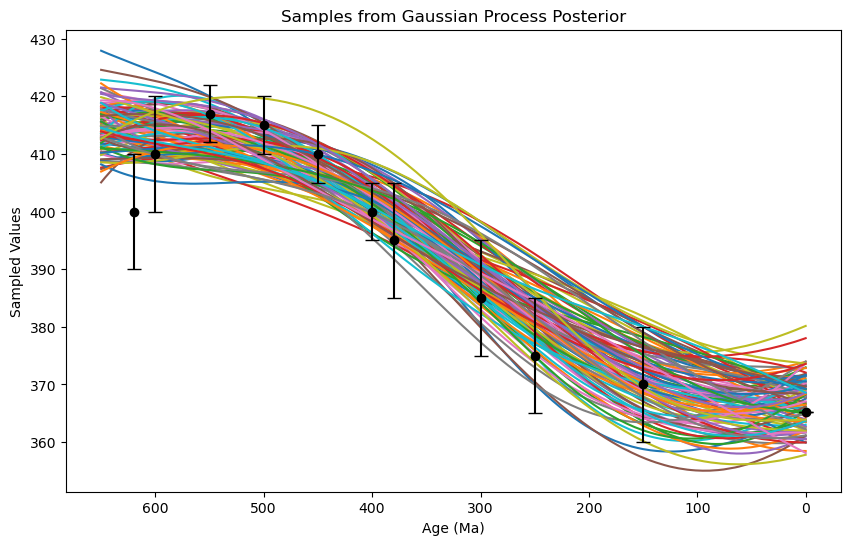

In [130]:
# Plot 10 draws from the posterior
sample_from_GP_posterior(cov_post_rescaled, mu_post_rescaled, X = X_test_rescaled, X_in = X_train_rescaled, Y_in = Y_train_rescaled, Y_error = df["Days/year error"].values.astype(float), k = 100)

## Define Negative Log Marginal Likelihood and Gradient function for combined kernel to efficiently find optimal hyperparameters

In [ ]:
def nlml_and_grad(log_params, X_train, y_train,
                  x_err_train, y_err, jitter=1e-8):
    """
    log_params: array of length 6:
      [log(sigma1), log(sigma2), sigmab (raw), log(lengthscale), c (raw), log(noise_floor)]
    X_train: (n,1)
    y_train: (n,) or (n,1)
    x_err_train: (n,) or (n,1) input std-deviations
    y_err: (n,) or (n,1) output std-deviations (measurement errors)
    Returns: (nlml_float, grad_array) where grad has same length as log_params
    """

    # Ensure shapes
    X = np.atleast_2d(X_train).reshape(-1,1)
    y = np.atleast_1d(y_train).reshape(-1,1)
    n = X.shape[0]
    xerr = (np.atleast_1d(x_err_train).reshape(-1,1) if x_err_train is not None else np.zeros((n,1)))
    yerr = (np.atleast_1d(y_err).reshape(-1,1) if y_err is not None else np.zeros((n,1)))

    # Unpack params carefully with correct casting
    log_sigma1 = float(log_params[0])
    log_sigma2 = float(log_params[1])
    sigmab = float(log_params[2])        # leave bias raw (can be negative)
    log_lengthscale = float(log_params[3])
    c = float(log_params[4])
    log_noise = float(log_params[5])

    sigma1 = np.exp(log_sigma1)
    sigma2 = np.exp(log_sigma2)
    lengthscale = np.exp(log_lengthscale)
    noise_floor = np.exp(log_noise)

    # Build covariance
    K = combined_kernel(X, X, xerr1=xerr, xerr2=xerr,
                        sigma1=sigma1, sigma2=sigma2, sigmab=sigmab,
                        lengthscale=lengthscale, c=c)
    # add heteroscedastic obs noise and small jitter
    K += np.diag((yerr.flatten()**2) + noise_floor) + jitter * np.eye(n)

    # Cholesky
    try:
        L = cholesky(K, lower=True)
    except np.linalg.LinAlgError:
        return np.inf, np.ones_like(log_params) * np.inf

    # Solve for alpha = K^{-1} y via cho_solve
    alpha = cho_solve((L, True), y)           # (n,1)
    # Compute K^{-1} (we will need it for gradients)
    K_inv = cho_solve((L, True), np.eye(n))   # (n,n)

    # NLML
    nlml = 0.5 * float(y.T @ alpha) + 0.5 * np.sum(np.log(np.diag(L))) * 2.0 + 0.5 * n * np.log(2*np.pi)
    # (note: sum log diag(L) *2 = log |K|)

    # Precompute matrix used in gradient: (alpha alpha^T - K^{-1})
    A = alpha @ alpha.T - K_inv   # (n,n)

    # --------------------
    # Compute derivatives dK/dtheta
    # for each hyperparameter in same order as log_params
    # --------------------
    # 1) dK/d log(sigma1) = dK/d sigma1 * sigma1 = sigma1 * K_rbf / sigma1 = K_rbf
    K_rbf = rbf_kernel_with_xerr(X, X, xerr1=xerr, xerr2=xerr, variance=1.0, lengthscale=lengthscale) * sigma1
    # but more precisely K_rbf currently equals sigma1 * ... so derivative wrt log(sigma1) is K_rbf

    # For clarity compute base rbf with variance=1 so we can form derivatives cleanly
    base_rbf_unit = rbf_kernel_with_xerr(X, X, xerr1=xerr, xerr2=xerr, variance=1.0, lengthscale=lengthscale)

    # dK/d log(sigma1) = K_rbf (sigma1 * base_rbf_unit)
    dK_dlog_sigma1 = sigma1 * base_rbf_unit

    # 2) dK/d log(sigma2) for linear variance:
    base_lin_unit = linear_kernel(X, X, variance=1.0, variance_b=0.0, c=c)
    dK_dlog_sigma2 = sigma2 * base_lin_unit

    # 3) dK/d sigmab (raw)
    dK_dsigmab = np.ones((n,n)) * 1.0  # derivative of sigmab contributes to every element as 1

    # 4) dK/d log(lengthscale)
    # Need derivative of rbf with respect to lengthscale, then chain-rule multiply by lengthscale (because param is log(lengthscale))
    # derivative of base_rbf_unit wrt lengthscale (non-log) can be derived from formula.
    # We'll compute d/dell base_rbf_unit numerically-stable analytic form below:
    s1 = (xerr**2).reshape(-1,1)
    s2 = s1.T
    denom = lengthscale**2 + s1 + s2         # (n,n)
    sqdist = (X - X.T)**2
    # base_rbf_unit = sqrt(lengthscale^2 / denom) * exp(-sqdist/(2*denom))
    # compute derivative d base_rbf_unit / d lengthscale:
    term1 = 0.5 * (2*lengthscale) / (lengthscale**2) * base_rbf_unit  # derivative from sqrt prefactor approx (we'll compute properly)
    # more carefully compute derivative analytically:
    # Let p = sqrt(lengthscale^2 / denom), q = exp(-sqdist / (2 denom))
    # d p / d ell = (ell / denom)**0.5 * (1/ell - ell/(denom)) ?? safer to compute full analytic below
    
    # We'll compute analytic derivative for base_rbf_unit w.r.t lengthscale (non-log) directly:
    # d/dell base = base * [ (ell/denom) - (ell * (sqdist) / denom**2) ] where proper factors applied.
    # Implement exact expression:
    # base = sqrt(ell^2 / denom) * exp(-sqdist/(2 denom))
    # ln(base) = 0.5*(ln(ell^2) - ln(denom)) - sqdist/(2 denom)
    # d ln(base)/d ell = (ell/ell^2) - (0.5 * (2*ell) /(denom)) + sqdist * ell /(denom**2)
    # Simplify numerically robustly below.
    ell = lengthscale
    # compute derivative of base_rbf_unit wrt ell (non-log)
    # using automatic rearranged expression:
    # d base / d ell = base * ( ell/ (ell**2) - ell/denom + sqdist * ell / (denom**2) )
    # = base * ( 1/ell - ell/denom + sqdist * ell/denom**2 )
    with np.errstate(divide='ignore', invalid='ignore'):
        dbase_dell = base_rbf_unit * ( (1.0/ell) - (ell/denom) + (sqdist * ell) / (denom**2) )
    # chain rule for log(lengthscale): d/d log(ell) = ell * d/dell
    dK_dlog_lengthscale = sigma1 * (ell * dbase_dell)

    # 5) dK/d c (raw) (affects linear kernel)
    # linear kernel K_lin = sigma2 * (X - c)(X - c)^T + sigmab
    # dK/dc = sigma2 * ( -1*(X - c) * 1^T  + -1* 1 * (X - c)^T ) = -sigma2 * [ (X-c) 1^T + 1 (X-c)^T ]
    xc = (X - c)
    dK_dc = -sigma2 * ( xc @ np.ones((1,n)) + np.ones((n,1)) @ xc.T )

    # 6) dK/d log(noise_floor) (for the extra noise floor)
    dK_dlog_noise = noise_floor * np.eye(n)

    # Pack derivatives in same order as input params: [log(sigma1), log(sigma2), sigmab, log(lengthscale), c, log(noise)]
    derivs = [
        dK_dlog_sigma1,
        dK_dlog_sigma2,
        dK_dsigmab,
        dK_dlog_lengthscale,
        dK_dc,
        dK_dlog_noise
    ]

    # Compute gradients: 0.5 * trace(A @ dK_dtheta)
    grads = np.empty(len(derivs), dtype=float)
    for i, dK in enumerate(derivs):
        grads[i] = 0.5 * np.sum(A * dK)   # trace(A @ dK) = sum elementwise of A * dK

    # Return nlml as float and gradient array (same ordering)
    return float(nlml), grads

## Test: play around with Gaussian process regression

### Use Radial Basis Function as kernel (no x-uncertainty)
Based on https://medium.com/data-science-at-microsoft/introduction-to-gaussian-process-regression-part-1-the-basics-3cb79d9f155f#b578

Script to play around with hyperparameters without optimization

In [ ]:
# 1. Prepare data
X_train = df["Age (Ma)"].values.reshape(-1, 1).astype(float)
y_train = df["Days/year"].values.astype(float)
y_error = df["Days/year error"].values.astype(float)

# Normalize input
X_mean = X_train.mean()
X_std = X_train.std()
X_train_norm = (X_train - X_mean) / X_std

# 3. Set hyperparameters
lengthscale = 2  # Lengthscale of the Radial Basis Function kernel
variance = 1000 # Variance of the kernel

# 4. Compute kernel matrices
K = rbf_kernel(X_train_norm, X_train_norm, lengthscale, variance) # Covariance matrix
K += np.diag((y_error**2))  # Add individual noise variances
K_inv = inv(K) # Inverse of covariance matrix

# 5. Predict on new input grid
X_test = np.linspace(0, 650, 500).reshape(-1, 1)
X_test_norm = (X_test - X_mean) / X_std
K_s = rbf_kernel(X_test_norm, X_train_norm, lengthscale, variance) # Cross-covariance between test and training data
K_ss = rbf_kernel(X_test_norm, X_test_norm, lengthscale, variance) + 1e-8 * np.eye(len(X_test)) # Covariance matrix for test data (adding small noise for numerical stability)

# 6. Posterior mean and covariance
mu_s = K_s @ K_inv @ y_train # Mean prediction
cov_s = K_ss - K_s @ K_inv @ K_s.T # Covariance of the prediction
std_s = np.sqrt(np.diag(cov_s)) # Standard deviation of the prediction

# 7. Plot
plt.figure(figsize=(10, 6))
plt.errorbar(X_train, y_train, yerr=y_error.flatten(), fmt='o', color='blue', label='Data with Uncertainty')
plt.plot(X_test, mu_s, 'r', label="GPR Mean")
plt.fill_between(X_test.flatten(),
                 (mu_s - 1.96 * std_s).flatten(),
                 (mu_s + 1.96 * std_s).flatten(),
                 color='red', alpha=0.3, label='GPR 95% CI')
plt.xlabel("Age (Ma)")
plt.ylabel("Days per Year")
plt.gca().invert_xaxis()
plt.title("Gaussian Process Regression with Radial Basis Function Kernel")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Use adapted Radial Basis Function kernel to accommodate y-uncertainty (WORK IN PROGRESS)
Adapted covariance function for uncertain inputs on both variables from Girard et al. (https://proceedings.neurips.cc/paper_files/paper/2002/hash/f3ac63c91272f19ce97c7397825cc15f-Abstract.html) and Rasmussen et al. (http://www.gaussianprocess.org/gpml/)

Script to play around with hyperparameters without optimization

In [ ]:
# Prepare data
X_train = df["Age (Ma)"].values.reshape(-1, 1).astype(float)
y_train = df["Days/year"].values.astype(float)
y_error = df["Days/year error"].values.astype(float)
x_error = df["Age error"].values.astype(float).reshape(-1, 1)

# Normalize inputs
X_mean, X_std = X_train.mean(), X_train.std()
X_train_norm = (X_train - X_mean) / X_std
x_error_norm = x_error / X_std  # Scale x uncertainties too

# Modified Radial Basis Function kernel including x_error
def rbf_kernel_with_xerr(X1, X2, xerr1, xerr2, lengthscale, variance):
    """Radial Basis Function kernel that accounts for Gaussian uncertainty in X."""
    # Pairwise squared distance
    sqdist = (X1 - X2.T)**2
    # Total lengthscale squared for each pair
    total_var = lengthscale**2 + xerr1**2 + xerr2.T**2
    scale_factor = (lengthscale**2 / total_var)**0.5
    return variance * scale_factor * np.exp(-0.5 * sqdist / total_var)

# # NLML function (for optimization)
# def nlml(params):
#     lengthscale = np.exp(params[0])
#     variance = np.exp(params[1])
#     noise_var = (y_error**2).flatten()
    
#     K = rbf_kernel_with_xerr(X_train_norm, X_train_norm, x_error_norm, x_error_norm, lengthscale, variance)
#     K += np.diag(noise_var)  # Add measurement noise in y
    
#     try:
#         L = cholesky(K)
#         alpha = solve(L.T, solve(L, y_train))
#         log_det_K = 2.0 * np.sum(np.log(np.diag(L)))
#         return 0.5 * y_train.T @ alpha + 0.5 * log_det_K + 0.5 * len(X_train) * np.log(2 * np.pi)
#     except np.linalg.LinAlgError:
#         return 1e10  # Penalize non-PD matrices

# # Optimize hyperparameters
# res = minimize(nlml, x0=[0.0, 0.0], bounds=[(-5, 5), (-5, 10)], method='L-BFGS-B')
# opt_lengthscale = np.exp(res.x[0])
# opt_variance = np.exp(res.x[1])
# print(f"Optimal lengthscale: {opt_lengthscale:.3f}, variance: {opt_variance:.3f}")

# 3. Set hyperparameters
lengthscale = 2  # Lengthscale of the RBF kernel
variance = 1000 # Variance of the kernel

# === 6. Predictions ===
X_test = np.linspace(0, 650, 500).reshape(-1, 1)
X_test_norm = (X_test - X_mean) / X_std
x_error_test = np.zeros_like(X_test_norm)  # Assume no horizontal error for prediction

K = rbf_kernel_with_xerr(X_train_norm, X_train_norm, x_error_norm, x_error_norm, lengthscale, variance)
K += np.diag((y_error**2).flatten() + 1e-6)
K_s = rbf_kernel_with_xerr(X_test_norm, X_train_norm, x_error_test, x_error_norm, lengthscale, variance)
K_ss = rbf_kernel_with_xerr(X_test_norm, X_test_norm, x_error_test, x_error_test, lengthscale, variance) + 1e-8 * np.eye(len(X_test)) # Add small noise for numerical stability

L = cholesky(K)
alpha = solve(L.T, solve(L, y_train))
mu_s = K_s @ alpha
v = solve(L, K_s.T)
cov_s = K_ss - v.T @ v
std_s = np.sqrt(np.clip(np.diag(cov_s), 0, np.inf))

# === 7. Plot ===
plt.figure(figsize=(10, 6))
plt.errorbar(X_train.flatten(), y_train.flatten(),
             xerr=x_error.flatten(), yerr=y_error.flatten(),
             fmt='o', color='blue', label="Data w/ Uncertainty")
plt.plot(X_test, mu_s, 'r', label="GP Mean (Optimized)")
plt.fill_between(X_test.flatten(),
                 (mu_s - 1.96 * std_s).flatten(),
                 (mu_s + 1.96 * std_s).flatten(),
                 color='red', alpha=0.3, label='95% CI')
plt.gca().invert_xaxis()
plt.xlabel("Age (Ma)")
plt.ylabel("Days per Year")
plt.title("GPR with Radial Basis Function Kernel Including X and Y Uncertainty")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Optimize hyperparameters

In [ ]:
# Negative Log Marginal Likelihood
def nlml(params):
    lengthscale = np.exp(params[0])  # log-param to ensure positivity
    variance = np.exp(params[1])
    noise_var = (y_error ** 2).flatten()

    K = rbf_kernel(X_train_norm, X_train_norm, lengthscale, variance)
    K += np.diag(noise_var)

    try:
        L = cholesky(K)
        alpha = solve(L.T, solve(L, y_train))
        log_det_K = 2.0 * np.sum(np.log(np.diag(L)))
        nlml_value = 0.5 * y_train.T @ alpha + 0.5 * log_det_K + 0.5 * len(X_train) * np.log(2 * np.pi)
        return nlml_value.flatten()[0]
    except np.linalg.LinAlgError:
        return 1e10  # Penalize bad matrix

# Optimize
res = minimize(nlml, x0=[0.0, 0.0], bounds=[(-5, 5), (-5, 10)], method='L-BFGS-B')
opt_lengthscale = np.exp(res.x[0])
opt_variance = np.exp(res.x[1])
print(f"Optimal lengthscale: {opt_lengthscale:.3f}, variance: {opt_variance:.3f}")

# Predict
X_test = np.linspace(0, 650, 500).reshape(-1, 1)
X_test_norm = (X_test - X_mean) / X_std
K = rbf_kernel(X_train_norm, X_train_norm, opt_lengthscale, opt_variance)
K += np.diag((y_error**2).flatten() + 1e-6)
K_s = rbf_kernel(X_test_norm, X_train_norm, opt_lengthscale, opt_variance)
K_ss = rbf_kernel(X_test_norm, X_test_norm, opt_lengthscale, opt_variance) + 1e-8 * np.eye(len(X_test))

L = cholesky(K)
alpha = solve(L.T, solve(L, y_train))
mu_s = K_s @ alpha
v = solve(L, K_s.T)
cov_s = K_ss - v.T @ v
std_s = np.sqrt(np.clip(np.diag(cov_s), 0, np.inf))

# 7. Plot
plt.figure(figsize=(10, 6))
plt.errorbar(X_train.flatten(), y_train.flatten(), yerr=y_error.flatten(), fmt='o', label="Data with Uncertainty", color='blue')
plt.plot(X_test, mu_s, 'r', label="GP Mean (Optimized)")
plt.fill_between(X_test.flatten(),
                 (mu_s - 1.96 * std_s).flatten(),
                 (mu_s + 1.96 * std_s).flatten(),
                 color='red', alpha=0.3, label='95% CI')
plt.gca().invert_xaxis()
plt.xlabel("Age (Ma)")
plt.ylabel("Days per Year")
plt.title("Optimized Gaussian Process Regression with Radial Basis Function Kernel")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Optimize with x error

In [ ]:
# Prepare data
X_train = df["Age (Ma)"].values.reshape(-1, 1).astype(float)
y_train = df["Days/year"].values.astype(float)
y_error = df["Days/year error"].values.astype(float)
x_error = df["Age error"].values.astype(float).reshape(-1, 1)

# Normalize X for better numerics
X_mean, X_std = X_train.mean(), X_train.std()
X_train_norm = (X_train - X_mean) / X_std
x_error_norm = x_error / X_std  # Scale x uncertainties too

# Modified Radial Basis Function kernel including x_error
def rbf_kernel_with_xerr(X1, X2, xerr1, xerr2, lengthscale, variance):
    """Radial Basis Function kernel that accounts for Gaussian uncertainty in X."""
    # Pairwise squared distance
    sqdist = (X1 - X2.T)**2
    # Total lengthscale squared for each pair
    total_var = lengthscale**2 + xerr1**2 + xerr2.T**2
    scale_factor = (lengthscale**2 / total_var)**0.5
    return variance * scale_factor * np.exp(-0.5 * sqdist / total_var)

# NLML function
def nlml(params):
    lengthscale = np.exp(params[0])
    variance = np.exp(params[1])
    noise_var = (y_error**2).flatten()
    
    K = rbf_kernel_with_xerr(X_train_norm, X_train_norm, x_error_norm, x_error_norm, lengthscale, variance)
    K += np.diag(noise_var + 1e-6)  # Add measurement noise in y
    
    try:
        L = cholesky(K)
        alpha = solve(L.T, solve(L, y_train))
        log_det_K = 2.0 * np.sum(np.log(np.diag(L)))
        return 0.5 * y_train.T @ alpha + 0.5 * log_det_K + 0.5 * len(X_train) * np.log(2 * np.pi)
    except np.linalg.LinAlgError:
        return 1e10  # Penalize non-PD matrices

# Optimize hyperparameters
res = minimize(nlml, x0=[0.0, 0.0], bounds=[(-5, 5), (-5, 10)], method='L-BFGS-B')
opt_lengthscale = np.exp(res.x[0])
opt_variance = np.exp(res.x[1])
print(f"Optimal lengthscale: {opt_lengthscale:.3f}, variance: {opt_variance:.3f}")

# Predictions
X_test = np.linspace(0, 650, 500).reshape(-1, 1)
X_test_norm = (X_test - X_mean) / X_std
x_error_test = np.zeros_like(X_test_norm)  # Assume no horizontal error for prediction

K = rbf_kernel_with_xerr(X_train_norm, X_train_norm, x_error_norm, x_error_norm, opt_lengthscale, opt_variance)
K += np.diag((y_error**2).flatten() + 1e-6)
K_s = rbf_kernel_with_xerr(X_test_norm, X_train_norm, x_error_test, x_error_norm, opt_lengthscale, opt_variance)
K_ss = rbf_kernel_with_xerr(X_test_norm, X_test_norm, x_error_test, x_error_test, opt_lengthscale, opt_variance) + 1e-8 * np.eye(len(X_test))

L = cholesky(K)
alpha = solve(L.T, solve(L, y_train))
mu_s = K_s @ alpha
v = solve(L, K_s.T)
cov_s = K_ss - v.T @ v
std_s = np.sqrt(np.clip(np.diag(cov_s), 0, np.inf))

# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(X_train.flatten(), y_train.flatten(),
             xerr=x_error.flatten(), yerr=y_error.flatten(),
             fmt='o', color='blue', label="Data w/ Uncertainty")
plt.plot(X_test, mu_s, 'r', label="GP Mean (Optimized)")
plt.fill_between(X_test.flatten(),
                 (mu_s - 1.96 * std_s).flatten(),
                 (mu_s + 1.96 * std_s).flatten(),
                 color='red', alpha=0.3, label='95% CI')
plt.gca().invert_xaxis()
plt.xlabel("Age (Ma)")
plt.ylabel("Days per Year")
plt.title("Gaussian Progress Regression with Radial Basis Function Kernel Including X and Y Uncertainty")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Constrain Gaussian Process Regression to enforce monotonicity
Following framework from Zhang et al. (https://arxiv.org/html/2507.06677v1)
but using a Maximum A Posteriori estimation for uncertainties instead of the Regularized Linear Randomize-Then-Optimize (RLRTO) described in the paper.

Script to play around with hyperparameters without optimization

In [ ]:
# Prepare data
X_obs = df["Age (Ma)"].values.reshape(-1, 1).astype(float)
y_obs = df["Days/year"].values.astype(float)
y_err = df["Days/year error"].values.astype(float).reshape(-1, 1)  # obs std dev

# Treat Age (Ma) as the GP input (1D)
# Choose grid for representing the latent function f(x)
X_grid = np.linspace(0.0, 650.0, 300).reshape(-1,1)  # dense grid covering the domain

# Kernel: Squared Exponential (Radial Basis Function)
def rbf(X1, X2, lengthscale=100.0, variance=200.0):
    # squared distances
    X1 = X1.reshape(-1,1); X2 = X2.reshape(-1,1)
    d2 = (X1**2).reshape(-1,1) + (X2**2).reshape(1,-1) - 2.0 * (X1 @ X2.T)
    return variance * np.exp(-0.5 * d2 / (lengthscale**2))

# Prior hyperparameters (tuneable)
lengthscale = 120.0   # in Ma (bigger = smoother)
variance = 400.0 # in days^2 (bigger = more variance)

# Compute K on grid
K = rbf(X_grid, X_grid, lengthscale=lengthscale, variance=variance)
jitter = 1e-8 * np.eye(K.shape[0]) # small numerical stability noise
K += jitter # add jitter to ensure positive-definiteness

# Precompute Cholesky matrix for applying K^{-1} efficiently
L_K = cholesky(K, lower=True)

# Linear operator mapping grid f -> predicted observables at X_obs
# We'll use linear interpolation (matrix) from grid to observation points
def build_interp_matrix(X_from, X_to):
    # X_from: grid, X_to: observation points
    # returns A shape (n_to, n_from) such that y_pred = A @ f_grid
    xf = X_from.ravel()
    xt = X_to.ravel()
    n_from = len(xf)
    n_to = len(xt)
    A = np.zeros((n_to, n_from))
    for i, x in enumerate(xt):
        if x <= xf[0]:
            A[i,0] = 1.0
        elif x >= xf[-1]:
            A[i,-1] = 1.0
        else:
            j = np.searchsorted(xf, x) - 1
            x0, x1 = xf[j], xf[j+1]
            w1 = (x - x0) / (x1 - x0)
            w0 = 1.0 - w1
            A[i, j] = w0
            A[i, j+1] = w1
    return A

A_obs = build_interp_matrix(X_grid, X_obs)   # maps f_grid -> y_pred at observations

# Monotonicity constraints: finite difference derivative >= 0
# Build linear operator D such that D @ f_grid = approximate derivative at midpoints
# and require D @ f_grid >= 0
xf = X_grid.ravel()
dx = np.diff(xf)  # spacing (non-uniform allowed)
n_grid = len(xf)
n_der = n_grid - 1
D = np.zeros((n_der, n_grid))
for i in range(n_der):
    # forward difference derivative at interval i: (f[i+1] - f[i]) / dx[i]
    D[i, i]   = -1.0 / dx[i]
    D[i, i+1] =  1.0 / dx[i]

# We want monotonic increasing with Age, so we keep D @ f_grid >= 0
lincon = LinearConstraint(D, lb=np.zeros(D.shape[0]), ub=np.full(D.shape[0], np.inf))

# Objective: negative log posterior (up to constant) for f_grid
#   0.5 * (f - m)^T K^{-1} (f - m) + 0.5 * sum((A_obs f - y_obs)^2 / sigma_y^2)
# We'll take prior mean m as a weak linear trend fitted to data (optional)
# set prior mean m: linear fit in x->y space (helps numerics)
coefs = np.polyfit(X_obs.ravel(), y_obs.ravel(), deg=1)
m_grid = np.polyval(coefs, X_grid.ravel()).reshape(-1,1)

# noise variances for obs (use y_err; if zero, set small floor)
sigma_y2 = np.clip((y_err.ravel())**2, 1e-6, None)
W_inv = np.diag(1.0 / sigma_y2)  # shape (n_obs, n_obs)

# Helper: compute K^{-1} @ v using cho_solve (stable)
def Kinv_dot(v):
    # v shape (..., n_grid) or (n_grid,)
    return cho_solve((L_K, True), v)

# Objective and gradient
def objective(f_vec):
    # f_vec is 1D array length n_grid
    f = f_vec.reshape(-1,1)
    r = f - m_grid
    # prior term: 0.5 * r^T K^{-1} r
    Ki_r = Kinv_dot(r)
    prior_term = 0.5 * float(r.T @ Ki_r)
    # data term: 0.5 * (A f - y)^T W_inv (A f - y)
    Af = A_obs @ f
    resid = Af - y_obs
    data_term = 0.5 * float(resid.T @ W_inv @ resid)
    return prior_term + data_term

def grad_obj(f_vec):
    f = f_vec.reshape(-1,1)
    r = f - m_grid
    # gradient prior: K^{-1} r
    grad_prior = Kinv_dot(r)  # shape (n_grid,1)
    # gradient data: A^T W_inv (A f - y)
    Af = A_obs @ f
    resid = Af - y_obs
    grad_data = A_obs.T @ (W_inv @ resid)
    grad = (grad_prior + grad_data).ravel()
    return grad

# Initial guess: posterior mean from unconstrained GP (conditioning on the data)
# Solve for unconstrained predictive mean on grid: m_grid + K_grid_obs K_obs_obs^{-1} (y - m_obs)
# where K_grid_obs = K(X_grid, X_obs), K_obs_obs from observations' induced kernel on obs points
# Simpler: compute by solving the linear system via interpolation mapping A_obs.
# We'll compute the MAP without monotonicity first as init.
# Build smaller matrices using grid->obs mapping to form the posterior:
K_gg = K  # (n_grid x n_grid)
K_gg_A_T = A_obs.T  # not direct kernel; easier to do direct conditioning via penalized formulation below
# Use the minimizer initial guess as m_grid
x0 = m_grid.ravel()

# Run constrained optimization
print("Starting constrained optimization (this may take some seconds)...")
res = minimize(fun=objective, x0=x0, jac=grad_obj, method='trust-constr',
               constraints=[lincon],
               options={'verbose': 2, 'maxiter': 500})
if not res.success:
    print("Optimization warning:", res.message)
f_map = res.x.reshape(-1,1)   # MAP estimate on grid

# Approximate posterior covariance at the MAP (Laplace-ish approximation)
# We approximate posterior covariance of f_grid as (K^{-1} + A^T W_inv A)^{-1}
# Use the matrix-free solve via Cholesky if feasible (here n_grid ~ 300 OK)
from scipy.linalg import cho_factor, cho_solve
B = K.copy()
# compute S = K @ A_obs.T @ W_inv @ A_obs @ K  not needed; instead compute inverse of
# H = K^{-1} + A^T W_inv A  => compute matrix H and invert via cholesky
# Build H explicitly (n_grid x n_grid)
H = cho_solve((L_K, True), np.eye(K.shape[0]))  # K^{-1}
H += A_obs.T @ W_inv @ A_obs
# invert H
L_H = cholesky(H, lower=True)
Cov_f = cho_solve((L_H, True), np.eye(H.shape[0]))  # approximate posterior covariance
std_f = np.sqrt(np.clip(np.diag(Cov_f), 0, np.inf)).reshape(-1,1)

# Plot results
plt.figure(figsize=(10,6))
# Observed data with errorbars
plt.errorbar(X_obs.ravel(), y_obs.ravel(),
             xerr=None, yerr=y_err.ravel(), fmt='o', label='Observed data', color='k')

# MAP mean and 95% credible band
plt.plot(X_grid.ravel(), f_map.ravel(), color='C1', lw=2, label='Constrained GP (MAP)')
plt.fill_between(X_grid.ravel(),
                 (f_map.ravel() - 1.96*std_f.ravel()),
                 (f_map.ravel() + 1.96*std_f.ravel()),
                 color='C1', alpha=0.25, label='Approx. 95% CI')

# Also plot prior mean (linear) for reference
plt.plot(X_grid.ravel(), m_grid.ravel(), '--', color='gray', label='Prior mean (linear)')

plt.gca().invert_xaxis()  # consistent with geology plots (old on left)
plt.xlabel('Age (Ma)')
plt.ylabel('Days per Year')
plt.title('GP with monotonicity constraints (MAP estimate)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
